In [2]:
# %% Import and stuff
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import time
import random
import torchvision.utils as vutils
from  torch.utils import data
from mpl_toolkits.axes_grid1 import ImageGrid
import math
from collections import OrderedDict
from torch.utils.data import Subset
from datetime import datetime 
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as tran
from scipy import linalg

from torchvision.models import inception_v3
from scipy.stats import entropy


NUM_EPOCHS = 10
LR = 0.0002
LATENT_DIM = 100
IMG_SIZE = 28
CHANNELS = 1
B1 = 0.5
B2 = 0.999


GEN_STATE_DICT = "gen_state_dict"
DISC_STATE_DICT = "disc_state_dict"
GEN_OPTIMIZER = "gen_optimizer"
DISC_OPTIMIZER = "disc_optimizer"
G_LOSSES = "g_losses"
D_LOSSES = "d_losses"

SHUFFLE = True
PIN_MEMORY = True
NUM_WORKERS = 0
BATCH_SIZE = 2000

img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:{}'.format(device))


Device:cpu


In [3]:
# %% helper funcitons

def save_checkpoint(state, filename):
    print("=> Saving chekpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint):
    generator.load_state_dict(checkpoint[GEN_STATE_DICT])
    optimizer_G.load_state_dict(checkpoint[GEN_OPTIMIZER])
    discriminator.load_state_dict(checkpoint[DISC_STATE_DICT])
    optimizer_D.load_state_dict(checkpoint[DISC_OPTIMIZER])
    G_losses = checkpoint[G_LOSSES]
    D_losses = checkpoint[D_LOSSES]
    

def gen_image(caption=-1,randomLatent=True):
    generator.to('cpu')
    discriminator.to('cpu')

    with torch.no_grad():

      f, axarr = plt.subplots(1)
      
      latent = torch.rand_like(torch.Tensor(1,100))     
      if caption == -1:
          caption = random.randint(0, 9)
      
      caption = torch.tensor(caption, dtype=torch.int64)
      fake_image = generator(latent,caption)  
      
      axarr.imshow(fake_image[0][0])   
      print("Supposed to be %d" %caption.item())

      
        
def discriminate_image(caption=-1,genOrReal=0):#random.randint(0, 1)):
    generator.to('cpu')
    discriminator.to('cpu')
    
    with torch.no_grad():
        for  i, (imgs, labels) in enumerate(example_loader):
            f, axarr = plt.subplots(1)
            
            labels = labels.to('cpu')
            z = Variable(Tensor(np.random.normal(0, 1, (1,LATENT_DIM)))).cpu()
            if caption == -1:
                caption = random.randint(0, 9)
            caption = torch.tensor(caption, dtype=torch.int64)
            
            
            #feed discriminator fake image, expect "0" output
            if genOrReal == 0:
                fake_image = generator(z,caption)
                axarr.imshow(fake_image[0].reshape(-1, 28, 28)[0])
                pred = discriminator(fake_image,caption).detach()
                print("Discriminator Prediction: {},Should be: {}, label = {}".format(pred,"0",caption))
            #feed discriminator real image, expect "1" output
            else:
                fake_image = generator(z,labels[0])
                axarr.imshow(imgs[0].reshape(-1, 28, 28)[0])
                pred = discriminator(imgs.detach(),labels[0].detach()).detach()
                print("Discriminator Prediction: {},Should be: {}, label= {}".format(pred,"1",labels[0]+1))
            
    
            break
def is_normalized(image):
  
  tensor_image_normalized = image[0]  # your tensor image here

  min_value = tensor_image_normalized.min().item()
  max_value = tensor_image_normalized.max().item()

  
  return (min_value >= -1.0 and max_value <= 1.0)

In [4]:
# %%train data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    ])


train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)



train_loader = data.DataLoader(
                                train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS,
                                pin_memory=False,
                                drop_last=True
                                )

test_loader = data.DataLoader(
                                train_dataset,
                                batch_size=60000,
                                shuffle=False,
                                num_workers=NUM_WORKERS,
                                pin_memory=False
                                )

example_loader = data.DataLoader(
                                train_dataset,
                                batch_size=1,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True,
                                )


100%|██████████| 9912422/9912422 [00:00<00:00, 80057519.59it/s]


Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 79070296.23it/s]


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21596840.36it/s]


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12599556.06it/s]


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



In [5]:
# %% Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(2, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

        self.emb = nn.Embedding(10, 50)
        self.emb_fc = nn.Linear(50, 784)

        self.nconv1 = nn.Conv2d(2, 64, kernel_size=5)
        self.nconv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=3)
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        self.nfc1 = nn.Linear(1152, 164)
        self.nfc2 = nn.Linear(164, 1)

    def forward(self, x, c,t3 =-1):

        if  type(t3) == int:
            c = self.emb(c)
        else:
            c = t3
        c = self.emb_fc(c)
        c = c.view(-1, 1, 28, 28)
        x = torch.cat((c, x), 1)  # concat image[1,28,28] with text [1,28,28]

        x = F.leaky_relu(self.nconv1(x))
        x = F.leaky_relu(self.nconv2(x))
        x = self.pool(x)
        x = self.pool2(x)
        x = x.view(-1, 1152)
        x = F.leaky_relu(self.nfc1(x))
        x = F.dropout(x, training=self.training)
        x = self.nfc2(x)

        x = torch.sigmoid(x)
        return x

# Check if a tensor image is normalized in [-1,1]
# returns true if it s within [-1,1]
def is_normalized(image):
  
  tensor_image_normalized = image[0]  # your tensor image here

  min_value = tensor_image_normalized.min().item()
  max_value = tensor_image_normalized.max().item()

  
  return (min_value >= -1.0 and max_value <= 1.0)


def colorize(image):
  return torch.cat([image, image, image], dim=1)

In [6]:
# %% Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(LATENT_DIM, 7*7*63)  # [n,100]->[n,3087]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)  # [n, 64, 16, 16] [32,..,..]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)  # [n, 32, , ]->[n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 16, 34, 34]-> [n, 1, 28, 28]
        
        self.emb = nn.Embedding(10, 50) 
        #self.emb2 = nn.Embedding(10, 50) 

        
        self.label_lin = nn.Linear(50, 49)
        self.conv_x_c = nn.ConvTranspose2d(65, 64, 4, stride=2)  # upsample [65,7,7] -> [64,14,14]
        self.tanh = nn.Tanh()

    def forward(self, x, c1, c2 = -1, w = round(random.uniform(0.0, 1), 1)):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)  # (n,100) -> (n,3087)
        x = F.leaky_relu(x)
        x = x.view(-1, 63, 7, 7)  # (n,3087) -> (63,7,7)
        
        #Encode label
        c1 = self.emb(c1)  # (n,) -> (n,50)
        c = c1
        
       
        if type(c2) == torch.Tensor: 
            c2 = self.emb(c2)
            c1 = c1[:,:math.floor(c1.size(1) - c1.size(1)*w)]  # slice tensor depending on w
            c2 = c2[:,:math.floor(c2.size(1) - c2.size(1)*(1-w))]
            c = torch.cat((c1, c2), 1)

        #encoded caption
        t3 = c
        c = self.label_lin(c)  # (n,50) -> (n,49)
        c = c.view(-1, 1, 7, 7)  # (n,49) -> (n,1,7,7)
        x = torch.cat((c, x), 1) # concat image[63,7,7] with text [1,7,7]
        
        x = self.ct1(x)  
        x = F.leaky_relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.leaky_relu(x)

        # Convolution to 28x28 (1 feature map)
        x = self.tanh(self.conv(x))
        return x

In [7]:
# %% Loss fucntion, optimizers
loss_func = nn.BCELoss()
#d_loss_func = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    loss_func.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR,betas=(B1 ,B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR,betas=(B1 ,B2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor   

In [8]:
#if you're running this on colab, download corresponding chackpoint file and upload it to runtime
load_checkpoint(torch.load("cond_gan_pytorch10.pth.tar",map_location=(device)))

Supposed to be 7


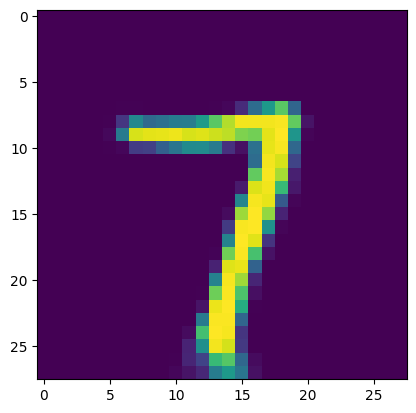

In [9]:
#Test image generation
gen_image()

In [10]:
#Generate batch of fake and real samples 
fake_images = []
real_images = []
device='cpu'
with torch.no_grad():
    generator.to('cpu')
    discriminator.to('cpu')

    for i, (imgs,label) in enumerate(train_loader):
        real_images = imgs
        
        #caption = random.randint(0, 9)   
        #caption = torch.tensor(caption, dtype=torch.int64)
        #latent = torch.rand_like(torch.Tensor(1,100))
        #fake_images = generator(latent,caption)
        
        
        for i in range(len(real_images[:])):
          caption = label[i]
          latent = torch.rand_like(torch.Tensor(1,100))
          fake_image = generator(latent,caption)

          if (i==0):
            fake_images = generator(latent,caption)
          else:
            fake_images = torch.cat((fake_images, fake_image), 0)
        break

print('Generated %d samples'
%(len(fake_images[:])))
#fake_images
#real_images


Generated 2000 samples


In [35]:
#idea from here: https://liorsinai.github.io/coding/2022/12/29/denoising-diffusion-2-unet.html#mjx-eqn-eqFrechet
#Calculate mean of real images
random.seed(42)

mnist_means = []
samples = 50


# convert dataset to numpy array
test_array = np.array([(np.array(x), y) for x, y in test_loader.dataset])
# for each number(0,9)
for num in range(10):
  # get indices of images with the current number
  indices = np.where(test_array[:, 1] == num)[0]
  # randomly sample max number of images
  subset_indices = random.sample(indices.tolist(), samples) if len(indices) > samples else indices
  subset_array = test_array[subset_indices]

  # compute mean of sampled images using numpy
  number_mean = np.mean(subset_array[:, 0], axis=0)

  mnist_means.append(torch.from_numpy(number_mean))
  

mnist_mean = torch.stack(mnist_means, dim=0)


<ipython-input-35-deedba0d7a4c>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_array = np.array([(np.array(x), y) for x, y in test_loader.dataset])


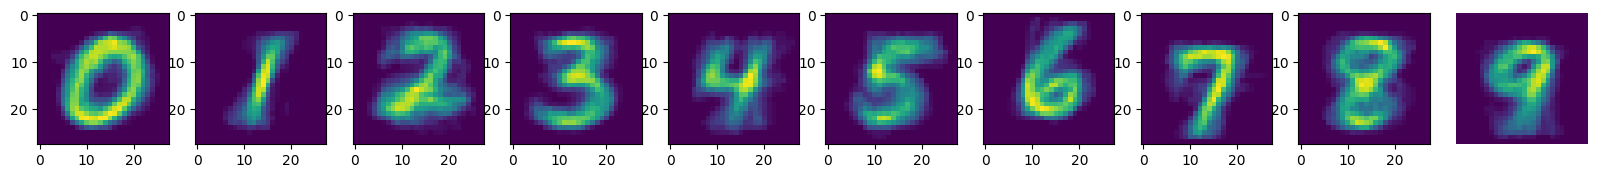

In [26]:
fig, axes = plt.subplots(nrows=1,ncols=10,figsize=(20,2.5))
plt.axis('off')


for i in range(len(mnist_mean[:])):
  axes[i].imshow(mnist_mean[i][0])

plt.show()    

Define the distance as the minimum of the mean Euclidean distance of x
to each mean $\bar{x}k$ :
 
 $$d=\min _{0 \leq k \leq 9} \frac{1}{W H} \sqrt{\sum_i^W \sum_j^H\left(x_{i j}-\bar{x}_{k, i j}\right)^2}$$

The score is the average of $d$ over all samples.


In [31]:
#Calculate average distances

num_samples = 1000
fake_images_means = []
fake_image_mean = []

distances = []
with torch.no_grad():
  for num in range(10):
    for i in range(num_samples):
      latent = torch.rand_like(torch.Tensor(1,100))
      caption = torch.tensor(num, dtype=torch.int64)
      
      fake_image = generator(latent,caption)  
      fake_image_mean.append(fake_image[0])
    
    fake_image_mean = torch.stack(fake_image_mean,dim=0)
    fake_image_mean = torch.mean(fake_image_mean, dim=0)

    fake_images_means.append(fake_image_mean)
    fake_image_mean = []  

fake_images_means = torch.stack(fake_images_means,dim=0)
fake_images_means.shape
  

torch.Size([10, 1, 28, 28])

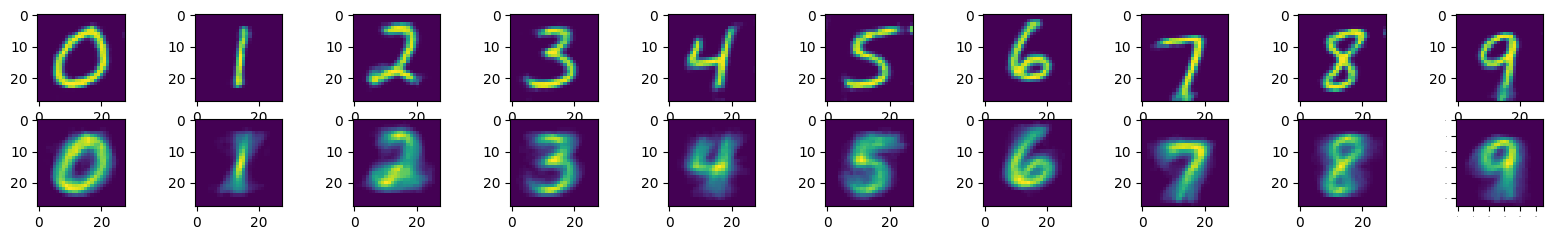

In [37]:
#Mean of generated vs actual images
fig, axes = plt.subplots(nrows=2,ncols=10,figsize=(20,2.5))
plt.tick_params(labelsize=0)


for i in range(len(mnist_mean[:])):
  axes[1][i].imshow(mnist_mean[i][0])
for i in range(len(fake_images_means[:])):
  axes[0][i].imshow(fake_images_means[i][0])



In [40]:
#calculate distances
#distances = [[0] * len(mnist_mean) for _ in range(10)]
distances = []

for i in range(len(fake_images_means[:])):

  diff = mnist_mean[i] - fake_images_means[i]
  distance = torch.norm(diff, p=2)
  
  distances.append(distance.item())

  print('Number: %d, Distance: %.4f'
  %(i,distance.item()))

# Print the distance
print(sum(distances)/len(distances))

Number: 0, Distance: 9.9282
Number: 1, Distance: 5.4011
Number: 2, Distance: 9.1169
Number: 3, Distance: 7.8627
Number: 4, Distance: 8.0213
Number: 5, Distance: 10.2496
Number: 6, Distance: 7.7363
Number: 7, Distance: 8.9085
Number: 8, Distance: 8.3720
Number: 9, Distance: 7.5208
8.311745214462281


In [ ]:
#model from here: https://github.com/erykml/medium_articles/blob/master/Computer%20Vision/lenet5_pytorch.ipynb
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
LEARNING_RATE = 0.001
N_CLASSES = 10

model = LeNet5(N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
#Load checkpoint
leNet_load_checkpoint = torch.load('leNet_checkpoint.pth.tar')

model.load_state_dict(leNet_load_checkpoint['leNet_model_state_dict'])
optimizer.load_state_dict(leNet_load_checkpoint['leNet_optmizer_state_dict'])

In [ ]:
#Frechet LeNet Distance
def calculate_activation_statistics(images, model):
  with torch.no_grad():
    model.eval()
    activations = []
    
    features = model.feature_extractor(images)
    activations.append(features)
    
    activations = np.concatenate(activations, axis=0)
    mu = np.mean(activations, axis=0)

    activations = activations.reshape(activations.shape[0], -1)  # flatten the activations to 2D

    sigma = np.cov(activations, rowvar=False)
    return mu, sigma


def calculate_frechet_distance(mu1, cov1, mu2, cov2):
  eps = 1e-6
  diff = mu1 - mu2
  # Product of two covariance matrices
  cov_mean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)
  if not np.isfinite(cov_mean).all():
      offset = np.eye(cov1.shape[0]) * eps
      cov_mean = linalg.sqrtm((cov1 + offset).dot(cov2 + offset))
  # Compute the Wasserstein-2 distance
  return np.sum(diff ** 2) + np.trace(cov1 + cov2 - 2 * cov_mean)



# Generate fake data and compute statistics
resize = tran.Resize((32, 32))



fake_big = resize(fake_images)
real_big = resize(real_images)

mu1, cov1 = calculate_activation_statistics(fake_big, model)
mu2, cov2 = calculate_activation_statistics(real_big, model)
frechet_distance = calculate_frechet_distance(mu1, cov1, mu2, cov2)

print("Frechet_distance between real and generated images is: %.6f"
  %(frechet_distance))




/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Frechet_distance between real and generated images is: 14.828684
